In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from tqdm import tqdm
import wandb

In [2]:
# Initialize Weights & Biases (wandb)
wandb.init(project="agco-anomaly-classification", entity="sameerhashmi1995")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sameerhashmi1995. Use `wandb login --relogin` to force relogin


Dataset class

In [3]:
class CustomImageDataset(Dataset):
    """
    Custom dataset class for loading images from root directory.
    It reads images from 'normal' and 'anomalous' folders and assigns labels accordingly.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = {'normal': 0, 'anomalous': 1}

        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for img_file in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_file)
                    self.data.append(img_path)
                    self.labels.append(self.classes[label])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = plt.imread(img_path)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

Data Analysis

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])


In [5]:
dataset = CustomImageDataset(root_dir='./datasets/agco_without_labels/', transform=transform)

In [6]:
# Shuffle and split the dataset into train (65%), val (20%), and test (15%)
dataset_size = len(dataset)
train_size = int(0.65 * dataset_size)
val_size = int(0.20 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [7]:
normal_count = sum(1 for label in dataset.labels if label == 0)
anomalous_count = len(dataset) - normal_count

In [11]:
print(f'Normal: {normal_count}, Anomalous: {anomalous_count}')
print("Train dataset length: ",len(train_dataset), ", Val dataset length: ", len(val_dataset), ", Test dataset length: ", len(test_dataset))

Normal: 3536, Anomalous: 1125
Train dataset length:  3029 , Val dataset length:  932 , Test dataset length:  700


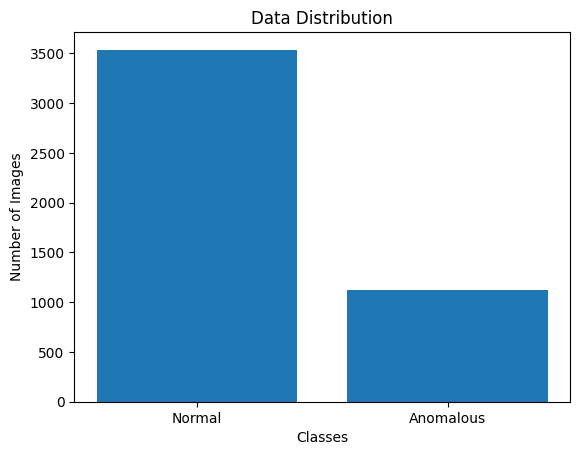

In [12]:
# Visualizing data distribution

plt.bar(['Normal', 'Anomalous'], [normal_count, anomalous_count])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Data Distribution')
plt.show()

In [13]:
# Calculating Mean and Standard Deviation
loader = DataLoader(dataset, batch_size=64, shuffle=False)
mean = torch.zeros(3).to('cuda')
std = torch.zeros(3).to('cuda')
nb_samples = 0

In [14]:
for data, _ in loader:
    data = data.to('cuda')
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [15]:
mean /= nb_samples
std /= nb_samples
print(f'Mean: {mean}, Std: {std}')

Mean: tensor([0.3670, 0.3722, 0.3348]), Std: tensor([0.1515, 0.1511, 0.1861])


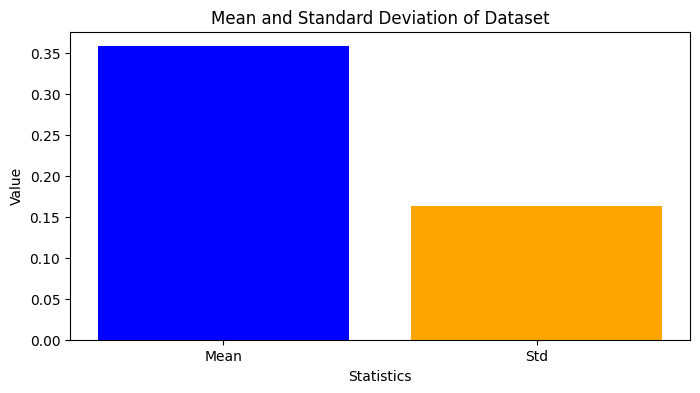

In [16]:
plt.figure(figsize=(8, 4))
plt.bar(['Mean', 'Std'], [mean.mean().item(), std.mean().item()], color=['blue', 'orange'])
plt.xlabel('Statistics')
plt.ylabel('Value')
plt.title('Mean and Standard Deviation of Dataset')
plt.show()

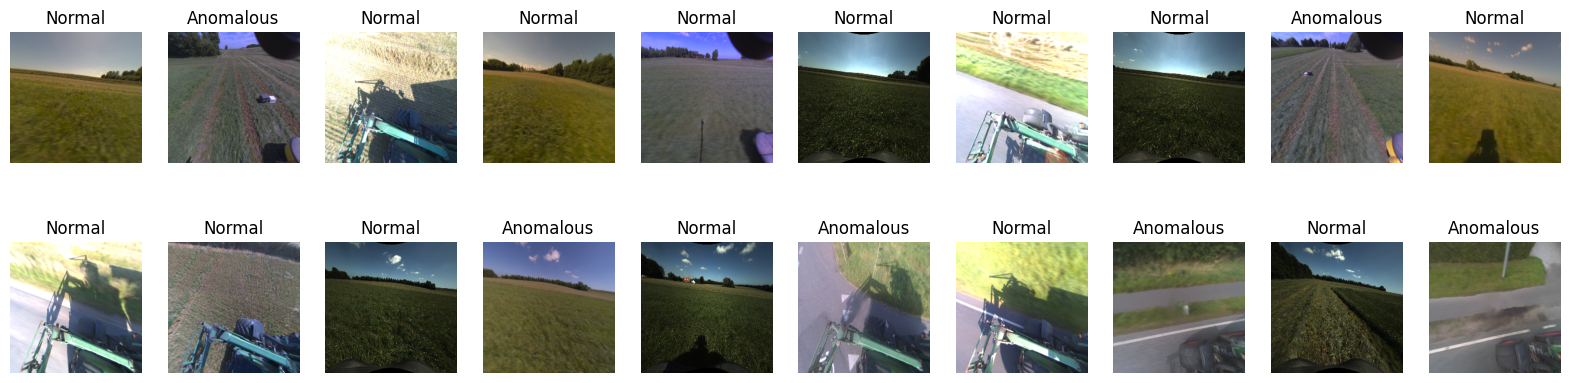

In [17]:
# Visualizing some data

plt.figure(figsize=(20, 5))
for i in range(20):
    idx = torch.randint(0, len(dataset), (1,)).item()
    image, label = dataset[idx]
    plt.subplot(2, 10, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title('Normal' if label == 0 else 'Anomalous')
    plt.axis('off')
plt.show()

Resnet Model

In [18]:
class ResNet18(nn.Module):
    """
    Custom ResNet18 model for binary classification (Normal vs Anomalous).
    """
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)  # 2 classes (Normal, Anomalous)

    def forward(self, x):
        return self.model(x)

Training, Val and testing functions

In [19]:
def train_model(model, criterion, optimizer, dataloader, device):
    """
    Function to train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = 100 * correct / total
    wandb.log({"Train Loss": epoch_loss, "Train Accuracy": accuracy})
    return epoch_loss, accuracy

In [20]:
def validate_model(model, criterion, dataloader, device):
    """
    Function to validate the model after each epoch.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = 100 * correct / total
    wandb.log({"Validation Loss": epoch_loss, "Validation Accuracy": accuracy})
    return epoch_loss, accuracy

In [21]:
def test_model(model, dataloader, device):
    """
    Function to test the model on the test dataset.
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return y_true, y_pred


Training and Validation

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, device)
    val_loss, val_acc = validate_model(model, criterion, val_loader, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f'best_model.pth')
        print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_acc:.2f}%')

Epoch [1/10], Train Loss: 0.2819, Train Acc: 87.92%, Val Loss: 0.1681, Val Acc: 95.06%


Epoch [2/10], Train Loss: 0.0805, Train Acc: 97.33%, Val Loss: 0.1888, Val Acc: 94.31%


Epoch [3/10], Train Loss: 0.0368, Train Acc: 98.84%, Val Loss: 0.1505, Val Acc: 95.82%


Epoch [4/10], Train Loss: 0.0252, Train Acc: 99.37%, Val Loss: 0.1629, Val Acc: 95.60%


Epoch [5/10], Train Loss: 0.0140, Train Acc: 99.64%, Val Loss: 0.1755, Val Acc: 96.03%


Epoch [6/10], Train Loss: 0.0134, Train Acc: 99.64%, Val Loss: 0.1856, Val Acc: 95.49%


Epoch [7/10], Train Loss: 0.0313, Train Acc: 99.11%, Val Loss: 0.1566, Val Acc: 96.24%


Epoch [8/10], Train Loss: 0.0262, Train Acc: 99.11%, Val Loss: 0.2174, Val Acc: 95.71%


Epoch [9/10], Train Loss: 0.0183, Train Acc: 99.47%, Val Loss: 0.1676, Val Acc: 96.14%


Epoch [10/10], Train Loss: 0.0080, Train Acc: 99.70%, Val Loss: 0.1647, Val Acc: 96.24%


Testing

In [26]:
y_true, y_pred = test_model(model, test_loader, device)

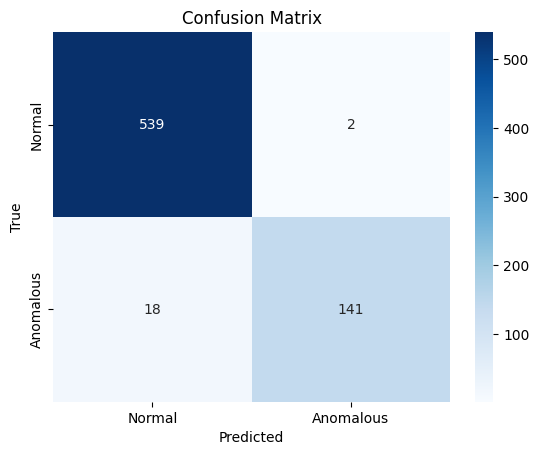

In [27]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Calculating Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Precision: 0.9860, Recall: 0.8868, F1 Score: 0.9338


In [29]:
# Logging metrics to wandb
wandb.log({"Precision": precision, "Recall": recall, "F1 Score": f1})

Visualizing some examples from TP, TN, FP and FN

In [60]:
def visualize_examples(y_true, y_pred, dataset):
    """
    Function to visualize True Positives, True Negatives, False Positives, and False Negatives.
    """
    tp_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == p == 1]
    tn_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == p == 0]
    fp_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == 0 and p == 1]
    fn_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == 1 and p == 0]

    indices = {
        'True Positive': tp_indices,
        'True Negative': tn_indices,
        'False Positive': fp_indices,
        'False Negative': fn_indices
    }

    plt.figure(figsize=(20, 10))
    for i, (label, idx_list) in enumerate(indices.items()):
        if len(idx_list) > 0:
            idx = idx_list[torch.randint(0, len(idx_list), (1,)).item()]
            image, true_label = dataset[idx]
            predicted_label = 'Normal' if label in ['True Negative', 'False Negative'] else 'Anomalous'
            plt.subplot(2, 4, i + 1)
            plt.imshow(image.permute(1, 2, 0))
            plt.title(f'{label}\nTrue: {"Normal" if true_label == 0 else "Anomalous"} | Pred: {predicted_label}')
            plt.axis('off')
    plt.show()


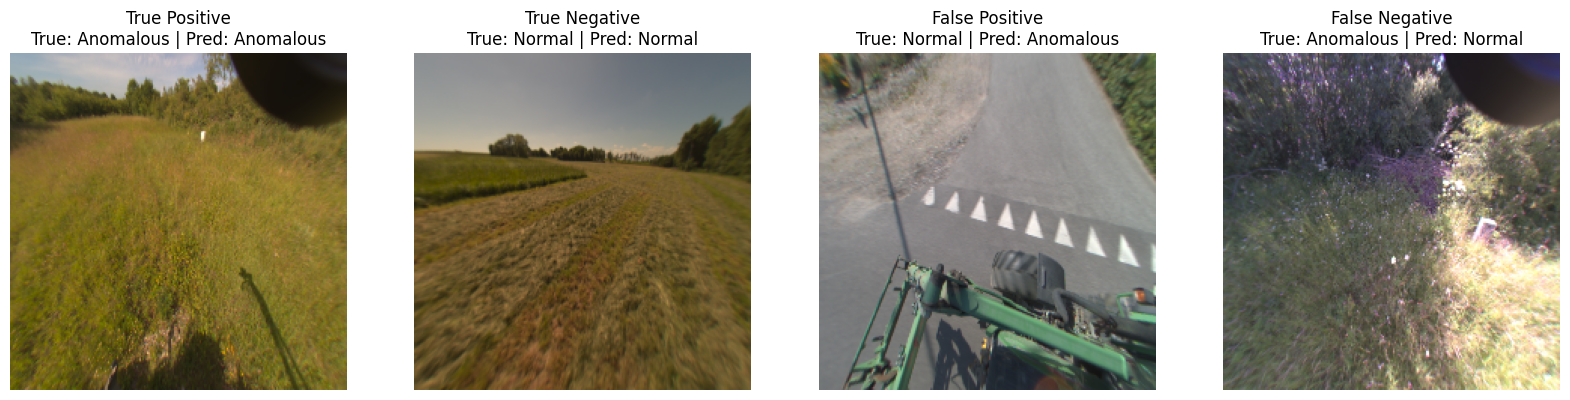

In [61]:
visualize_examples(y_true, y_pred, test_dataset)